# **DS340 Final Project - Predicting a Linear Congruential Generator (LCG)**
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Arjun Chandra and Chenqi Wang


**Brief Introduction**

A Linear Congruential Generator (LCG) is an algorithm used to produce pseudorandom numbers. The algorithm starts with a seed and generates a sequence of "random" numbers according to the following recurrence relation:

$$X_{n+1} = (a*X_n + c) \text{ mod } m$$

The values $a$, $c$, and $m$ are parameters of the generator. The initial generator state is the first number in the sequence after the seed. Each time a random number is requested, the generator state is returned and the state is advanced to the next number in the sequence. The goal of this project is to experiment with various generator parameters and neural network architectures to achieve a neural network which is able to learn the recurrence relation and predict the generator output.


**Motivation and Considerations**

While using a neural network to predict randomness appears an impossible task, LCG's only produce pseudorandom numbers which can often be correlated, especially with a poor choice of generator parameters. The image below highlights this idea. It is a bitmap where the pixels are randomly chosen to be be black or white (0 or 1) using an LCG.

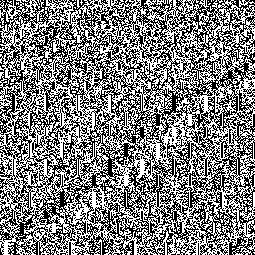

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;LCG Bitmap ([source](https://www.reedbeta.com/blog/quick-and-easy-gpu-random-numbers-in-d3d11/))

Evidently, there are patterns in the bitmap that a neural network could conceivably learn. That being said, it is difficult to imagine how a neural network would perform the modulus operation given that neural networks perform mostly linear operations save for activation functions, and the modulus operation is highly nonlinear. This is actually a well-studied problem and there are several key findings that will influence our approach and the architectures we use. First, the paper [here](https://www.inference.org.uk/sustainable/images/00256501.pdf) (Siu et al. 1993) proves that the modulus operation can be computed in a neural network with only 2 hidden layers. We should note that the weights in such a network are set by hand; there is no guarantee how many layers are necessary when the weights are learned. Still, for this reason, we won't consider using particularly deep networks. It is also possible that the network exhibits "grokking", a phenomena in which there is a sudden jump in validation accuracy long after the training data is learned. This occurred in previous [studies](https://arxiv.org/pdf/2301.02679.pdf) training neural networks to learn modular arithmetic. Finally, LCG's have a period length over which the sequence repeats, and we must be careful to filter out repeating sequences - otherwise the network would be able to find the output value in the input sequence.



...Let's get to it!

In [ ]:
#upgrade keras so we can use custom activation functions
%pip install --upgrade keras -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [12]:
"""
A Simple Class for an LCG
"""
class LCG:

  def __init__(self, a, c, m, seed):
    self.seed = seed
    self.a = a
    self.c = c
    self.m = m
    self.state = seed


  def get_random(self):
    """
    - Advances the generator state and returns the new state
    - If the new state is equal to the seed, return -1 to indicate the period
    length has been reached and the sequence is repeating
    """
    self.state = (self.a*self.state + self.c) % self.m

    if self.state == self.seed:
      return -1
    else:
      return self.state


  def get_period_length(self):
    """
    - Returns the period length of the LCG
    - For our purposes if the period length is >100,000 we just return
    100,000
    """
    #inital period length is equal to 1 - just the seed
    period_length = 1

    next = (self.a*self.seed + self.c) % self.m

    while next != self.seed:
      period_length += 1
      next = (self.a*next + self.c) % self.m

      if period_length >= 10**5:
        return 10**5

    return period_length


  def reset_state(self):
    """
    - Restores the inital generator state (the seed)
    """
    self.state = self.seed

  def set_seed(self, seed):
    """
    - Sets a new generator seed
    """
    self.seed = seed



Let's plot the sequence of numbers generated using the parameters from the Java SDK:

Text(0.5, 1.0, 'Example LCG Sequence - Java SDK')

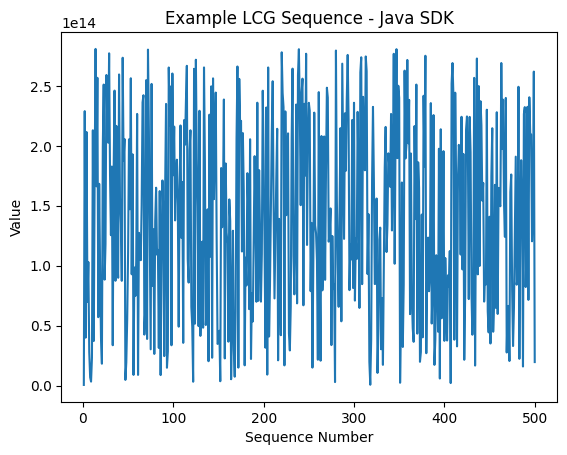

In [13]:
#JAVA SDK PARAMETERS

a = 25214903917
c = 11
m = 2**48
seed = 23
num_generations = 500

lcg1 = LCG(a, c, m, seed)

seq = [lcg1.get_random() for _ in range(num_generations)]
x = [i for i in range(1, num_generations+1)]

plt.plot(x, seq)
plt.xlabel("Sequence Number")
plt.ylabel("Value")
plt.title("Example LCG Sequence - Java SDK")

It looks pretty random! It also looks hard to predict, so we'll stick with "easier" parameters first while we experiment with the architecture and then see how well we do at the end with the Java LCG. In order to create a dataset, given that the LCG output is a sequence of numbers, we can divide up the sequence into smaller subsequences of ~10 numbers and have the first number after each subsequence be the target for that subsequence. When we split the dataset into training and validation sets, the subsequences in the validation set will come after all of the training subsequences to ensure that the model has not seen future data with respect to the validation set. We will try using a vanilla neural network, an RNN, and an LSTM. As for the parameters, we'll start by trying to learn an LCG sequence with $a=1229$, $c=1$, $m=2^{11}$, and 10 generations for each sequence. There's a nice animation at the bottom of this [page](https://rpubs.com/aaronsc32/linear-congruential-generator-r) showing why these parameters might be easy to learn.

In [19]:
"""
Helper functions to generate datasets and plot training results
"""

def plot_metrics(results):
  """
  Plots the training metrics as a 2x2 table with train and val loss and MAE
  """
  figure, axis = plt.subplots(2, 2)

  figure.tight_layout(pad=3.0)

  axis[0,0].plot(results.history['loss'])
  axis[0,1].plot(results.history['val_loss'])
  axis[1,0].plot(results.history['mean_absolute_error'])
  axis[1,1].plot(results.history['val_mean_absolute_error'])

  axis[0,0].set_title("Training Loss")
  axis[0,1].set_title("Validation Loss")
  axis[1,0].set_title("Training MAE")
  axis[1,1].set_title("Validation MAE")
  axis[0,0].set_xlabel("Epoch")
  axis[0,1].set_xlabel("Epoch")
  axis[1,0].set_xlabel("Epoch")
  axis[1,1].set_xlabel("Epoch")


def generate_data(lcg, subseq_length):
  """
  - Generates training data for an LCG with the specified subsequence lengths
  - The training data will be normalized by dividing by m
  """
  x_train = []
  y_train = []

  period = lcg.get_period_length()
  count = 0

  while count < period:
    subseq = []

    for _ in range(subseq_length):
      subseq.append(lcg.get_random())
      count += 1

    target = lcg.get_random()
    count += 1

    if count < period:
      x_train.append(subseq)
      y_train.append(target)

  x_train = np.array(x_train, dtype = 'float64')
  y_train = np.array(y_train, dtype = 'float64')

  #normalizing data
  x_train /= m

  return x_train, y_train


Generating the dataset:

In [ ]:
a = 1229
c = 1
m = 2048
seed = 323432
subseq_length = 10

lcg2 = LCG(a, c, m, seed)

#data is not shuffled because validation_split argument in model.fit() takes the
#last 10% of training samples for val
x_train, y_train = generate_data(lcg2, subseq_length)

We'll start by trying a vanilla neural network with two hidden layers:

In [16]:
input_shape = (10,)

shallowNN1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Dense(256, activation="sigmoid"),
        keras.layers.Dense(512, activation="linear"),
        keras.layers.Dense(1, activation="linear")
    ]
)

shallowNN1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,913 (527.00 KB)

 Trainable params: 134,913 (527.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 128
epochs = 200

shallowNN1.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.MeanAbsoluteError()])

results = shallowNN1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1237156.2500 - mean_absolute_error: 944.3764 - val_loss: 476008.4375 - val_mean_absolute_error: 578.2495
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 378200.3750 - mean_absolute_error: 520.1064 - val_loss: 358681.2812 - val_mean_absolute_error: 522.1579
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 347443.5625 - mean_absolute_error: 511.4613 - val_loss: 358186.3125 - val_mean_absolute_error: 521.7625
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 342756.1562 - mean_absolute_error: 504.8764 - val_loss: 357661.1562 - val_mean_absolute_error: 521.3170
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 349346.0000 - mean_absolute_error: 513.1562 - val_loss: 357221.6250 - val_mean_absolute_error: 520.9115
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 349388.7812 - mean_absolute_error: 512.7958 - val_loss: 356309.9375 - val_mean_absolute_error: 520.1395
Epoch 7/200
64/64 ━━

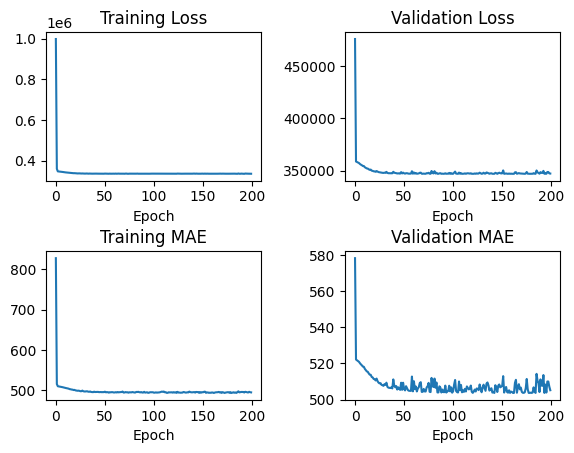

In [ ]:
plot_metrics(results)

The results don't look great considering the training and validation MAE were about the same at ~500 and the targets  are in the range [0, 2048). It seems like most of the learning happens relatively early and stalls out. We'll try using an RNN instead as this could be better suited to processing the sequence of random numbers.

In [ ]:
input_shape = (10,1)

RNN1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.SimpleRNN(256, activation="tanh"),
        keras.layers.Dense(1, activation="linear")
    ]
)

RNN1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 256)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 128
epochs = 200

RNN1.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.MeanAbsoluteError()])

results = RNN1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1363100.7500 - mean_absolute_error: 1007.9604 - val_loss: 1336969.6250 - val_mean_absolute_error: 988.9777
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1313126.8750 - mean_absolute_error: 981.7536 - val_loss: 1303271.6250 - val_mean_absolute_error: 972.4010
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1285273.2500 - mean_absolute_error: 966.9261 - val_loss: 1271140.2500 - val_mean_absolute_error: 956.5331
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1282583.8750 - mean_absolute_error: 971.2443 - val_loss: 1240203.1250 - val_mean_absolute_error: 941.3237
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1231413.8750 - mean_absolute_error: 942.1954 - val_loss: 1210320.0000 - val_mean_absolute_error: 926.7289
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1178592.8750 - mean_absolute_error: 916.3456 - val_loss: 1181145.7500 - val_mean_absolute_error: 912.5594
Epo

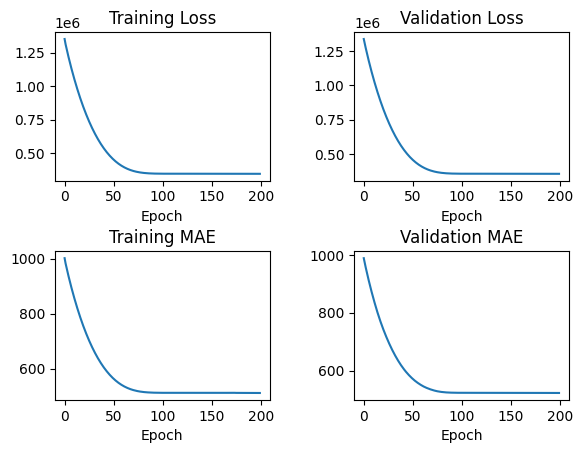

In [ ]:
plot_metrics(results)

The results are similar to the vanilla NN with the training and validation MAE plateauing at ~500, although learning seems to take significantly longer. Let's try an LSTM.

In [ ]:
input_shape = (10,1)

LSTM1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.LSTM(256, activation="tanh"),
        keras.layers.Dense(1, activation="linear")
    ]
)

LSTM1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 128
epochs = 200

LSTM1.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.MeanAbsoluteError()])

results = LSTM1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 1363877.2500 - mean_absolute_error: 1007.8185 - val_loss: 1334971.2500 - val_mean_absolute_error: 987.9929
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 1320914.2500 - mean_absolute_error: 986.1348 - val_loss: 1301211.6250 - val_mean_absolute_error: 971.3869
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 1288969.8750 - mean_absolute_error: 969.3350 - val_loss: 1269683.0000 - val_mean_absolute_error: 955.8115
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 1265911.6250 - mean_absolute_error: 956.6762 - val_loss: 1239522.6250 - val_mean_absolute_error: 940.9913
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 1231706.2500 - mean_absolute_error: 941.8724 - val_loss: 1210327.8750 - val_mean_absolute_error: 926.7327
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 1181017.3750 - mean_absolute_error: 917.4849 - val_loss: 1181759.5000 - val_mean_absolute_error: 912.8585
E

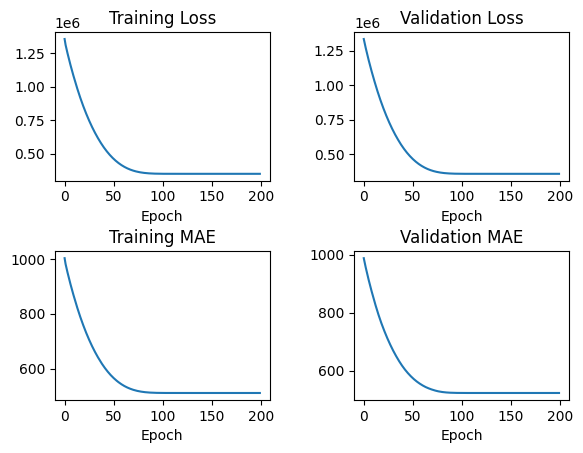

In [ ]:
plot_metrics(results)

The results are almost identical to the RNN. None of these results are very promising, but since the vanilla NN learned much faster than the recurrent architecures, we'll stick with it going forward. We will also undo the normalization that was applied earlier to the input sequences because after normalization the inputs are on a much smaller scale than the targets, and this seems like this would actually make learning harder.

In [ ]:
#undoing the normalization so the input values are on the same scale as the targets
x_train *= m

In [ ]:
batch_size = 128
epochs = 200

shallowNN1.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.MeanAbsoluteError()])

results_norm = shallowNN1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 67249.9531 - mean_absolute_error: 196.6100 - val_loss: 69793.3828 - val_mean_absolute_error: 194.4937
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63579.0039 - mean_absolute_error: 188.7281 - val_loss: 66006.2969 - val_mean_absolute_error: 192.8629
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60515.0508 - mean_absolute_error: 186.6945 - val_loss: 66040.5625 - val_mean_absolute_error: 193.6315
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61262.6445 - mean_absolute_error: 189.8760 - val_loss: 65421.6367 - val_mean_absolute_error: 192.9592
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58453.0586 - mean_absolute_error: 184.1627 - val_loss: 59875.0742 - val_mean_absolute_error: 182.5181
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56557.2344 - mean_absolute_error: 180.9384 - val_loss: 64037.0703 - val_mean_absolute_error: 188.0740
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━

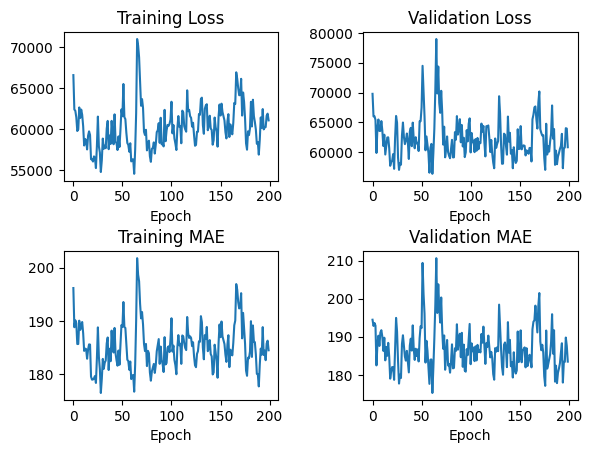

In [ ]:
plot_metrics(results_norm)

This looks a lot better than before - the MAE fluctuates around 190! Let's try switching the sigmoid activation in the first layer to a cosine function. This isn't a very common choice for an activation function but introducing periodicity in the model could potentially help to learn the modulus operation.

In [ ]:
#Same architecture as ShallowNN1 but the first layer uses a cosine activation function

input_shape = (10,)

shallowNN2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Dense(256, activation=keras.ops.cos),
        keras.layers.Dense(512, activation="linear"),
        keras.layers.Dense(1, activation="linear")
    ]
)

shallowNN2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                     │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,913 (527.00 KB)

 Trainable params: 134,913 (527.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 128
epochs = 200

shallowNN2.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.MeanAbsoluteError()])

results_cos = shallowNN2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1395397.6250 - mean_absolute_error: 1025.6702 - val_loss: 1399821.3750 - val_mean_absolute_error: 1019.8752
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1401516.3750 - mean_absolute_error: 1024.6987 - val_loss: 1380483.3750 - val_mean_absolute_error: 1010.5287
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1382841.7500 - mean_absolute_error: 1014.7159 - val_loss: 1342583.7500 - val_mean_absolute_error: 991.5587
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1321058.1250 - mean_absolute_error: 985.2258 - val_loss: 1282450.2500 - val_mean_absolute_error: 963.2848
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1264037.2500 - mean_absolute_error: 958.0725 - val_loss: 1201462.8750 - val_mean_absolute_error: 921.4855
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1175307.1250 - mean_absolute_error: 915.4702 - val_loss: 1112898.0000 - val_mean_absolute_error: 880.6417
Epoc

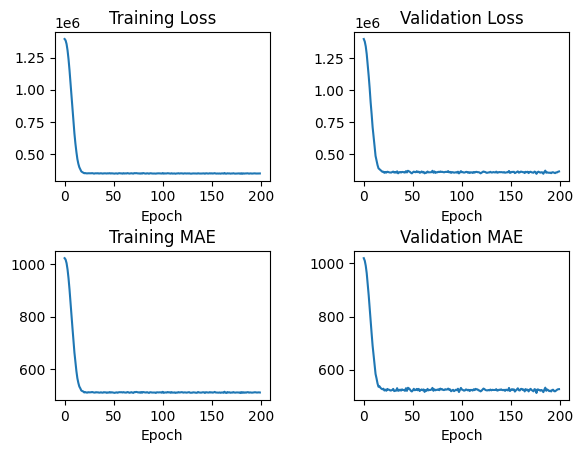

In [ ]:
plot_metrics(results_cos)

It was worth a shot but we'll stick with the sigmoid as the cosine does not seem to work well at all. Now we'll try to change the setup of the dataset so we input a single number at a time and fix the target to be the next number in the sequence as opposed to using subsequences for the input. This could help because each number in the sequence only depends directly on the previous number, so giving the model entire subsequences could have been distracting.

In [ ]:
def generate_one_to_one(lcg):
  """
  - Generates one to one training data for an LCG
  - Each consecutive pair of number in the sequence form an (x,y) pair for training
  - Data is not normalized since normalization seemed to make training worse
  """
  x_train = []
  y_train = []

  period = lcg.get_period_length()
  count = 0

  for i in range(0, period, 2):
    x_train.append(lcg.get_random())
    y_train.append(lcg.get_random())

  x_train = np.array(x_train, dtype = 'float64')
  y_train = np.array(y_train, dtype = 'float64')

  return x_train, y_train

In [ ]:
lcg2.reset_state()

x_train, y_train = generate_one_to_one(lcg2)

In [ ]:
#Same architecture as shallowNN1 but only 1 input

input_shape = (1,)

shallowNN3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Dense(256, activation="sigmoid"),
        keras.layers.Dense(512, activation="linear"),
        keras.layers.Dense(1, activation="linear")
    ]
)

shallowNN3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,609 (518.00 KB)

 Trainable params: 132,609 (518.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 200

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose = 1)

shallowNN3.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.MeanAbsoluteError()])

results_one_to_one = shallowNN3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.1, callbacks = [callback])

Epoch 1/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 480787.8438 - mean_absolute_error: 576.4404 - val_loss: 347172.5312 - val_mean_absolute_error: 509.1317
Epoch 2/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 344724.5000 - mean_absolute_error: 507.7001 - val_loss: 345099.9062 - val_mean_absolute_error: 507.5717
Epoch 3/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 345636.4688 - mean_absolute_error: 508.1358 - val_loss: 340988.2500 - val_mean_absolute_error: 503.9597
Epoch 4/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 342431.8750 - mean_absolute_error: 505.1922 - val_loss: 345792.1875 - val_mean_absolute_error: 509.3385
Epoch 5/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 343008.3125 - mean_absolute_error: 505.1941 - val_loss: 344939.9062 - val_mean_absolute_error: 508.2614
Epoch 6/200
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 342908.3438 - mean_absolute_error: 505.4776 - val_loss: 341866.2500 - val_mean_absolute_error: 503

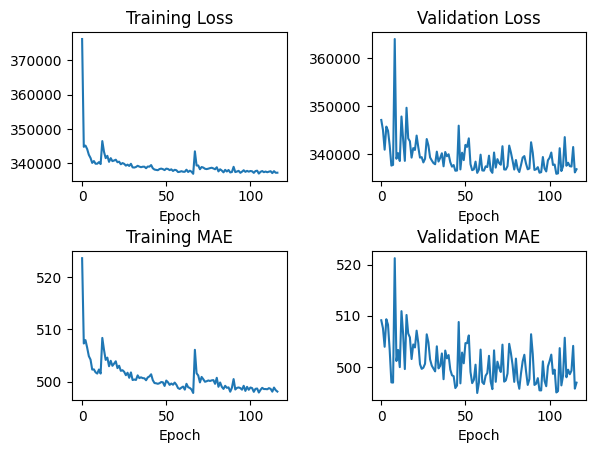

In [15]:
plot_metrics(results_one_to_one)

Reformulating the input to be only the number immediately preceding the target number did not seem to help.


**Conclusion**

There are probably endless ways we could keep tinkering with the setup and hyperparameters to achieve better results, and in fact there were several other things we tried without much success (batch size, other activation functions, deeper networks etc.) but these were omitted for the sake of keeping the notebook from being obnoxiously long. That being said, there are several interesting takeaways from this project. First, although normalization is standard practice for neural networks, our best model seemed to perform much better (~500 MAE → ~200 MAE) without normalization. Given that the numbers in the sequence are mostly evenly distributed in the range [0,2048), 200 MAE indicates that the model was at least able to develop a general idea of what the next number in the sequence would be. Second, even though the LCG sequence is formulated as a recurrence relation which only depends on the previous term, performance was much better when the models were given the sequence of the 10 terms preceding the target instead of only the previous term. This is perhaps the most noteable result because it seems to suggest that the network may not have been learning modular arithmetic at all but instead found a way to make use of older terms in the sequence to predict the next number. Finally, even though we were dealing with sequential data, the vanilla NN learned much faster than the RNN and LSTM architectures.

 Just for kicks, we'll try and train our best architecture on the Java LCG!

In [17]:
lcg1.reset_state()

x_train, y_train = generate_data(lcg1, subseq_length)
#undo normalization
x_train *= lcg1.m

batch_size = 128
epochs = 200

shallowNN1.compile(loss="mse", optimizer="adam", metrics=[keras.metrics.MeanAbsoluteError()])

results_java = shallowNN1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 26397464316446613821957603328.0000 - mean_absolute_error: 140810603462656.0000 - val_loss: 27261336261890923760189440000.0000 - val_mean_absolute_error: 143772184739840.0000
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 26391100927610946975032147968.0000 - mean_absolute_error: 140761412665344.0000 - val_loss: 27261336261890923760189440000.0000 - val_mean_absolute_error: 143772184739840.0000
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 26841720943322575695436054528.0000 - mean_absolute_error: 142484751515648.0000 - val_loss: 27261336261890923760189440000.0000 - val_mean_absolute_error: 143772184739840.0000
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 27030558934239567068241330176.0000 - mean_absolute_error: 143041872527360.0000 - val_loss: 27261336261890923760189440000.0000 - val_mean_absolute_error: 143772184739840.0000
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 26980693

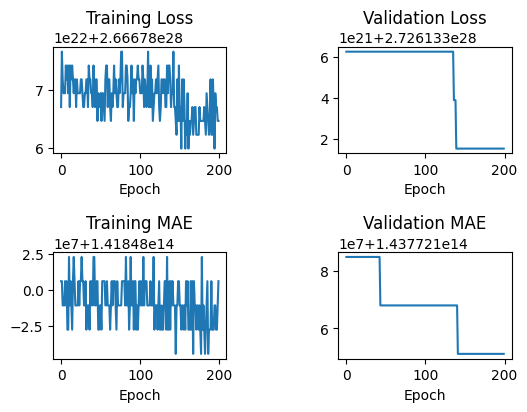

In [20]:
plot_metrics(results_java)

Our training metrics look like random number generators themselves! Not all hope is lost though - in our research we came across a lot of other interesting approaches to learning the modulus operation with a neural network. We won't list them all but [here](https://medium.com/@eric.lehman/modular-addition-in-neural-networks-36624afb90a7) is a particularly neat approach which formulates the problem of modular arithmetic as one in which a neural network is tasked with learning embeddings of real numbers in the complex plane where modular arithmetic can be carried out linearly using roots of unity $\dots$ how did we not think of that.

**END**